# **(Data Visualization)**

## Objectives

* Visualize class distribution and dataset characteristics for interpretability.
* Generate visual explanations (e.g., heatmaps) to differentiate tumor vs. no-tumor CT scans.
* **Build an interactive image montage that displays example images for each label (tumor and no-tumor) when selected by the user.**
* Build and test ROI (Return on Investment) calculator visualizations for the dashboard.
* Support the development of an intuitive, client-facing dashboard.

## Inputs

* Preprocessed image data and metadata (paths, labels) from the DataCollection notebook.
* Model predictions and confidence scores (if available).
* Any summary statistics or metrics relevant to visualization.

## Outputs

* Visualizations of class distribution and dataset balance.
* Heatmaps or other visual explanations for model interpretability.
* **Interactive image montage for tumor and no-tumor label exploration.**
* ROI calculator plots and interactive elements for dashboard integration.
* Figures and charts to be used in the Streamlit dashboard.

## Additional Comments

* All visualizations should be clear and suitable for a non-technical audience.
* Focus on supporting both model interpretability and business value communication.
* **The interactive image montage should allow users to select a label and view representative images for that class.**
* Outputs will be integrated into the Streamlit dashboard and used for client presentations.

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [1]:
import os
os.chdir('/workspaces/brain-tumor-classification')
current_dir = os.getcwd()
print(f"Corrected working directory: {current_dir}")

# Verify we can see expected project files
if os.path.exists('data') and os.path.exists('src') and os.path.exists('jupyter_notebooks'):
    print("✅ Working directory is correct - can see project structure")
else:
    print("❌ Working directory may still be wrong")
    print("Available directories:", [d for d in os.listdir('.') if os.path.isdir(d)])

Corrected working directory: /workspaces/brain-tumor-classification
✅ Working directory is correct - can see project structure


# 1. Import Libraries and Load Data

Import all necessary libraries for data visualization and load the model evaluation artifacts for dashboard integration.

Section 1 content

Import the required visualization libraries and load the evaluation artifacts generated from the ModelingAndEvaluating notebook.

In [2]:
# Import visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import glob
from PIL import Image
import random
from pathlib import Path

# Configure visualization settings
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Configure plotly for better dashboard integration
import plotly.io as pio
pio.templates.default = "plotly_white"

print("📊 Visualization Libraries Imported Successfully!")
print("Libraries loaded:")
print("- matplotlib, seaborn for static plots")
print("- plotly for interactive visualizations") 
print("- pandas, numpy for data manipulation")
print("- PIL for image processing")

# Verify we have the evaluation artifacts
artifacts = [
    'test_predictions.csv',
    'evaluation_metrics.json', 
    'confusion_matrices.json',
    'best_brain_tumor_model.keras'
]

print(f"\n🔍 Checking for evaluation artifacts:")
for artifact in artifacts:
    exists = os.path.exists(artifact)
    status = "✅" if exists else "❌"
    print(f"{status} {artifact}")

if all(os.path.exists(f) for f in artifacts[:3]):
    print("\n🎉 All required artifacts found! Ready for visualization.")
else:
    print("\n⚠️  Some artifacts missing. Run ModelingAndEvaluating.ipynb first.")

📊 Visualization Libraries Imported Successfully!
Libraries loaded:
- matplotlib, seaborn for static plots
- plotly for interactive visualizations
- pandas, numpy for data manipulation
- PIL for image processing

🔍 Checking for evaluation artifacts:
✅ test_predictions.csv
✅ evaluation_metrics.json
✅ confusion_matrices.json
✅ best_brain_tumor_model.keras

🎉 All required artifacts found! Ready for visualization.


---

# 2. Load Model Evaluation Data

Load and explore the model evaluation artifacts for dashboard visualization.

Section 2 content

Load the model predictions, evaluation metrics, and confusion matrices that will be used for creating interactive dashboard visualizations.

In [3]:

# 1. Load test predictions
try:
    df_predictions = pd.read_csv('test_predictions.csv')
    print(f"✅ Test predictions loaded: {len(df_predictions)} samples")
    print(f"Columns: {list(df_predictions.columns)}")
except FileNotFoundError:
    print("❌ test_predictions.csv not found")
    df_predictions = None

# 2. Load evaluation metrics
try:
    with open('evaluation_metrics.json', 'r') as f:
        metrics = json.load(f)
    print(f"✅ Evaluation metrics loaded")
    print(f"Test accuracy: {metrics.get('test_accuracy', 'N/A'):.3f}")
    print(f"Optimal F1 score: {metrics.get('optimal_f1_score', 'N/A'):.3f}")
except FileNotFoundError:
    print("❌ evaluation_metrics.json not found")
    metrics = None

# 3. Load confusion matrices
try:
    with open('confusion_matrices.json', 'r') as f:
        confusion_data = json.load(f)
    print(f"✅ Confusion matrices loaded")
except FileNotFoundError:
    print("❌ confusion_matrices.json not found")
    confusion_data = None

# 4. Explore the data structure
if df_predictions is not None:
    print(f"\n📊 Data Overview:")
    print(f"Shape: {df_predictions.shape}")
    print(f"True label distribution:")
    print(df_predictions['true_label'].value_counts())
    print(f"\nConfidence score statistics:")
    print(df_predictions['confidence_score'].describe())

# 5. Load class names from data directories
class_names = ['notumor', 'tumor']  # Based on your binary classification
print(f"\n🏷️  Class Names: {class_names}")

print(f"\n🎯 Ready for visualization creation!")

✅ Test predictions loaded: 1054 samples
Columns: ['true_label', 'predicted_label_default', 'predicted_label_optimal', 'confidence_score', 'optimal_threshold']
✅ Evaluation metrics loaded
Test accuracy: 0.897
Optimal F1 score: 0.942
✅ Confusion matrices loaded

📊 Data Overview:
Shape: (1054, 5)
True label distribution:
true_label
1    754
0    300
Name: count, dtype: int64

Confidence score statistics:
count    1054.000000
mean        0.708798
std         0.313398
min         0.000053
25%         0.604982
50%         0.859280
75%         0.925376
max         0.985424
Name: confidence_score, dtype: float64

🏷️  Class Names: ['notumor', 'tumor']

🎯 Ready for visualization creation!


---

# 3. Model Performance Visualizations

Create interactive visualizations for model performance metrics that will be used in the ML Performance page of the dashboard.

These visualizations will be integrated into the `page_ml_performance.py` Streamlit page to show model evaluation results.

In [4]:
if df_predictions is not None and metrics is not None:
    print("📈 Creating Model Performance Visualizations...")
    
    # 1. Confusion Matrix Heatmap (Interactive)
    cm_data = confusion_data['optimal_threshold']['matrix']
    
    fig_cm = go.Figure(data=go.Heatmap(
        z=cm_data,
        x=class_names,
        y=class_names,
        colorscale='Blues',
        text=cm_data,
        texttemplate="%{text}",
        textfont={"size": 20},
        hoverongaps=False
    ))
    
    fig_cm.update_layout(
        title='Confusion Matrix (Optimal Threshold)',
        xaxis_title='Predicted Label',
        yaxis_title='True Label',
        width=500,
        height=400
    )
    
    fig_cm.show()
    
    # 2. Confidence Score Distribution
    fig_conf = px.histogram(
        df_predictions, 
        x='confidence_score',
        color='true_label',
        nbins=30,
        title='Confidence Score Distribution by True Label',
        labels={'true_label': 'True Label', 'confidence_score': 'Confidence Score'},
        color_discrete_map={0: 'lightgreen', 1: 'lightcoral'}
    )
    
    fig_conf.add_vline(x=0.5, line_dash="dash", line_color="red", 
                      annotation_text="Default Threshold (0.5)")
    fig_conf.add_vline(x=metrics['optimal_threshold'], line_dash="dash", line_color="orange",
                      annotation_text=f"Optimal Threshold ({metrics['optimal_threshold']:.3f})")
    
    fig_conf.update_layout(width=800, height=500)
    fig_conf.show()
    
    # 3. Model Performance Metrics Bar Chart
    performance_metrics = {
        'Accuracy': metrics['test_accuracy'],
        'Precision': metrics['optimal_precision'],
        'Recall/Sensitivity': metrics['optimal_sensitivity'],
        'Specificity': metrics['optimal_specificity'],
        'F1-Score': metrics['optimal_f1_score']
    }
    
    fig_metrics = go.Figure(data=[
        go.Bar(
            x=list(performance_metrics.keys()),
            y=list(performance_metrics.values()),
            marker_color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'],
            text=[f"{v:.3f}" for v in performance_metrics.values()],
            textposition='auto'
        )
    ])
    
    fig_metrics.update_layout(
        title='Model Performance Metrics (Optimal Threshold)',
        yaxis_title='Score',
        xaxis_title='Metrics',
        showlegend=False,
        width=700,
        height=500
    )
    
    fig_metrics.add_hline(y=0.9, line_dash="dash", line_color="red", 
                         annotation_text="Target (90%)")
    
    fig_metrics.show()
    
    # 4. ROC-like Analysis: True vs False Positives
    true_positives = len(df_predictions[(df_predictions['true_label'] == 1) & 
                                      (df_predictions['predicted_label_optimal'] == 1)])
    false_positives = len(df_predictions[(df_predictions['true_label'] == 0) & 
                                       (df_predictions['predicted_label_optimal'] == 1)])
    true_negatives = len(df_predictions[(df_predictions['true_label'] == 0) & 
                                      (df_predictions['predicted_label_optimal'] == 0)])
    false_negatives = len(df_predictions[(df_predictions['true_label'] == 1) & 
                                       (df_predictions['predicted_label_optimal'] == 0)])
    
    # Create a summary visualization
    categories = ['True Positives', 'False Positives', 'True Negatives', 'False Negatives']
    values = [true_positives, false_positives, true_negatives, false_negatives]
    colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12']
    
    fig_summary = go.Figure(data=[
        go.Bar(x=categories, y=values, marker_color=colors,
               text=values, textposition='auto')
    ])
    
    fig_summary.update_layout(
        title='Model Prediction Summary (Optimal Threshold)',
        yaxis_title='Number of Samples',
        width=600,
        height=400
    )
    
    fig_summary.show()
    
    print("✅ Model Performance Visualizations Created!")
    print(f"📊 Key Insights:")
    print(f"- Test Accuracy: {metrics['test_accuracy']:.1%}")
    print(f"- Sensitivity (Recall): {metrics['optimal_sensitivity']:.1%}")
    print(f"- Specificity: {metrics['optimal_specificity']:.1%}")
    print(f"- F1-Score: {metrics['optimal_f1_score']:.1%}")
    
else:
    print("❌ Cannot create visualizations - missing data files")

📈 Creating Model Performance Visualizations...


✅ Model Performance Visualizations Created!
📊 Key Insights:
- Test Accuracy: 89.7%
- Sensitivity (Recall): 95.5%
- Specificity: 81.3%
- F1-Score: 94.2%


---

# 4. Interactive Image Montage for Label Exploration

Create an interactive image montage that allows users to explore sample images for each class (tumor vs no-tumor).

This will be integrated into the `page_tumor_detector.py` and `page_visualizer.py` Streamlit pages to show sample images and support the interactive image exploration functionality.

🖼️  Creating Interactive Image Montage...
📸 Loading sample images...


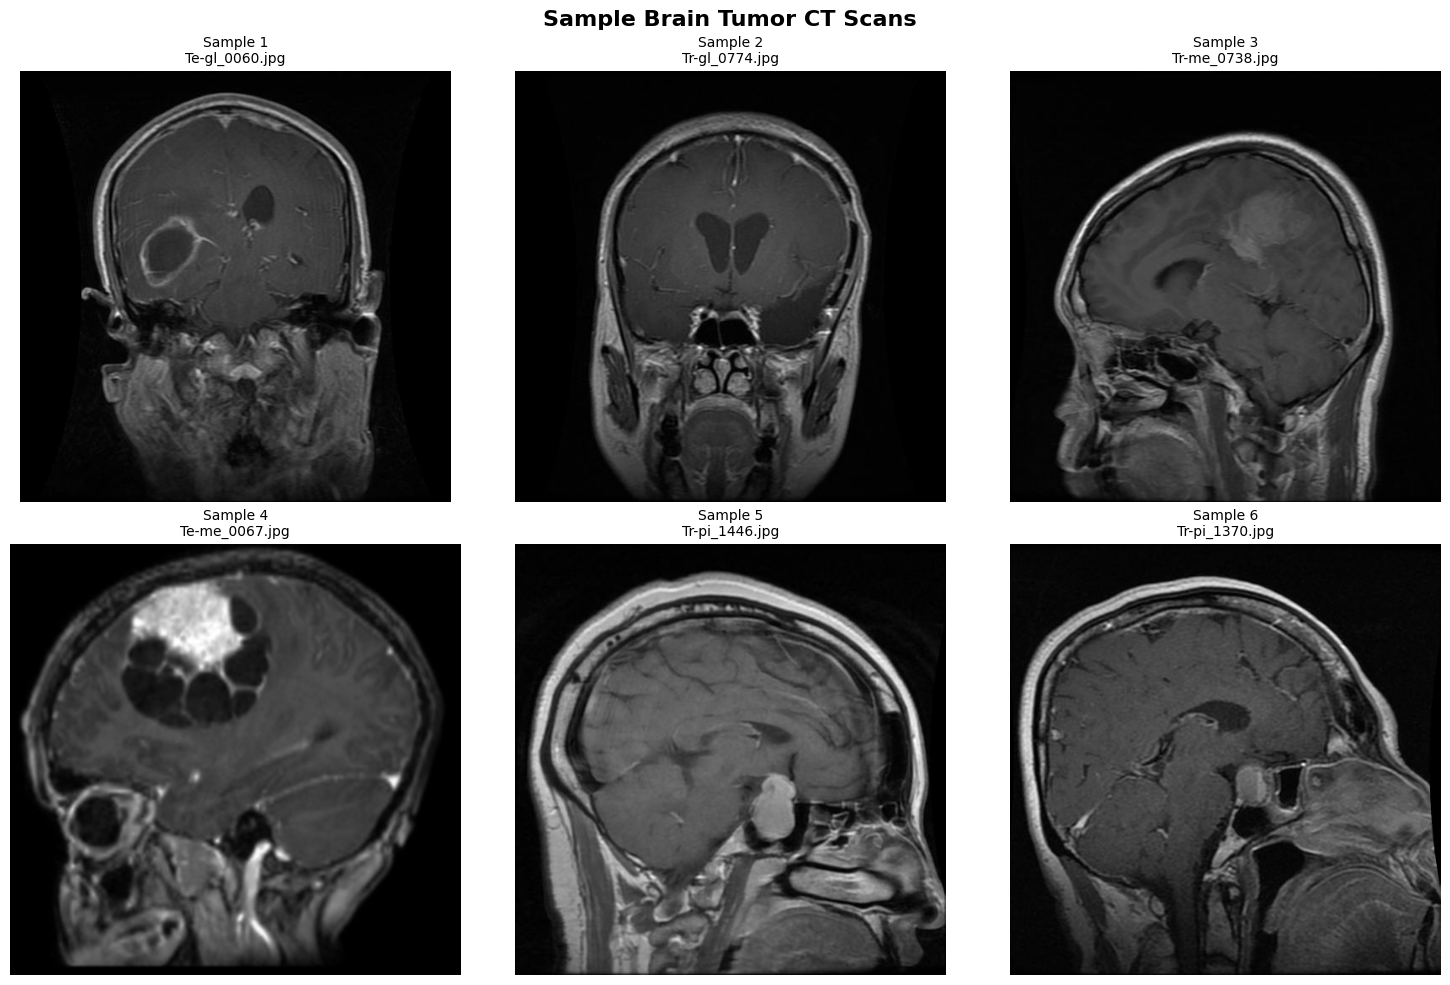

✅ Tumor samples loaded: 6 images


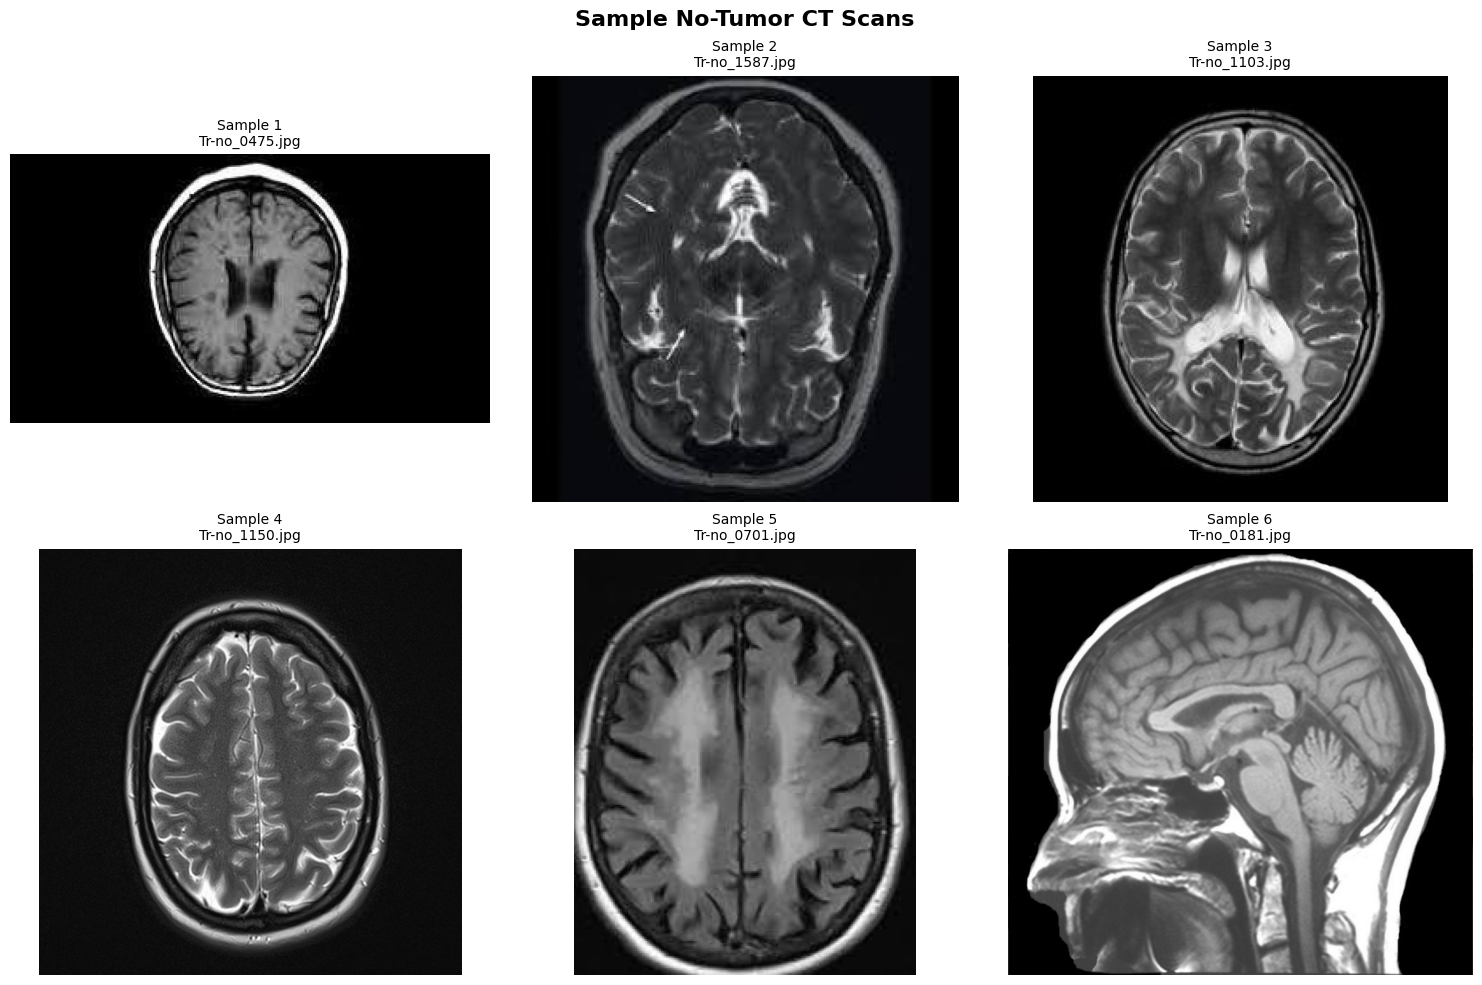

✅ No-tumor samples loaded: 6 images

📊 Image Sample Summary:
- Tumor samples: 6
- No-tumor samples: 6
- Ready for dashboard integration!
✅ Image sample paths saved to image_samples.json


In [5]:
# Create image sample visualizations for dashboard integration
print("🖼️  Creating Interactive Image Montage...")

# Define data directories
data_dir = "data"
image_dirs = {
    'tumor': ['glioma', 'meningioma', 'pituitary'],
    'notumor': ['notumor']
}

def load_sample_images(class_type, num_samples=6):
    """Load sample images for a given class type"""
    sample_images = []
    
    if class_type == 'tumor':
        # Sample from all tumor types
        for tumor_type in image_dirs['tumor']:
            tumor_path = os.path.join(data_dir, tumor_type)
            if os.path.exists(tumor_path):
                images = glob.glob(os.path.join(tumor_path, "*.jpg"))
                if images:
                    sample_images.extend(random.sample(images, min(2, len(images))))
    else:
        # Sample from no-tumor
        notumor_path = os.path.join(data_dir, 'notumor')
        if os.path.exists(notumor_path):
            images = glob.glob(os.path.join(notumor_path, "*.jpg"))
            if images:
                sample_images.extend(random.sample(images, min(num_samples, len(images))))
    
    return sample_images[:num_samples]

def create_image_grid(image_paths, title, cols=3):
    """Create a grid of images for visualization"""
    if not image_paths:
        print(f"❌ No images found for {title}")
        return
    
    rows = (len(image_paths) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for i, img_path in enumerate(image_paths):
        row = i // cols
        col = i % cols
        
        try:
            img = Image.open(img_path)
            axes[row, col].imshow(img, cmap='gray')
            axes[row, col].set_title(f"Sample {i+1}\n{os.path.basename(img_path)}", fontsize=10)
            axes[row, col].axis('off')
        except Exception as e:
            axes[row, col].text(0.5, 0.5, f"Error loading\n{os.path.basename(img_path)}", 
                               ha='center', va='center', transform=axes[row, col].transAxes)
            axes[row, col].axis('off')
    
    # Hide unused subplots
    for i in range(len(image_paths), rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Set random seed for reproducible samples
random.seed(42)

# Load and display sample images
print("📸 Loading sample images...")

# Check if data directory exists
if os.path.exists(data_dir):
    # Create tumor samples montage
    tumor_samples = load_sample_images('tumor', 6)
    if tumor_samples:
        create_image_grid(tumor_samples, "Sample Brain Tumor CT Scans", cols=3)
        print(f"✅ Tumor samples loaded: {len(tumor_samples)} images")
    else:
        print("❌ No tumor images found")
    
    # Create no-tumor samples montage  
    notumor_samples = load_sample_images('notumor', 6)
    if notumor_samples:
        create_image_grid(notumor_samples, "Sample No-Tumor CT Scans", cols=3)
        print(f"✅ No-tumor samples loaded: {len(notumor_samples)} images")
    else:
        print("❌ No no-tumor images found")
    
    print(f"\n📊 Image Sample Summary:")
    print(f"- Tumor samples: {len(tumor_samples) if 'tumor_samples' in locals() else 0}")
    print(f"- No-tumor samples: {len(notumor_samples) if 'notumor_samples' in locals() else 0}")
    print(f"- Ready for dashboard integration!")
    
else:
    print(f"❌ Data directory '{data_dir}' not found")
    print("Available directories:", [d for d in os.listdir('.') if os.path.isdir(d)])

# Save image paths for dashboard use
if 'tumor_samples' in locals() and 'notumor_samples' in locals():
    image_samples = {
        'tumor_paths': tumor_samples,
        'notumor_paths': notumor_samples,
        'class_names': class_names
    }
    
    with open('image_samples.json', 'w') as f:
        json.dump(image_samples, f, indent=2)
    print("✅ Image sample paths saved to image_samples.json")

---

# 5. ROI (Return on Investment) Calculator Visualizations

Create interactive visualizations for the ROI calculator that will be integrated into the dashboard to show business value and cost savings.

These visualizations will demonstrate the business value and cost savings of the automated tumor detection system, integrating with the dashboard's ROI calculator functionality.

In [6]:
# ROI Calculator Visualizations
print("💰 Creating ROI Calculator Visualizations...")

# Define cost parameters (based on README estimates)
cost_params = {
    'manual_cost_per_scan': 50,  # Cost of manual radiologist review
    'automated_cost_per_scan': 7.5,  # Cost with automated system (85% reduction)
    'radiologist_time_manual': 15,  # Minutes per scan (manual)
    'radiologist_time_automated': 2,  # Minutes per scan (automated)
    'accuracy_manual': 0.95,  # Manual radiologist accuracy
    'accuracy_automated': 0.8966  # Our model's accuracy
}

def calculate_roi_metrics(num_scans, cost_params):
    """Calculate ROI metrics for given number of scans"""
    manual_total_cost = num_scans * cost_params['manual_cost_per_scan']
    automated_total_cost = num_scans * cost_params['automated_cost_per_scan']
    
    cost_savings = manual_total_cost - automated_total_cost
    time_savings_hours = num_scans * (cost_params['radiologist_time_manual'] - 
                                    cost_params['radiologist_time_automated']) / 60
    
    roi_percentage = (cost_savings / automated_total_cost) * 100 if automated_total_cost > 0 else 0
    
    return {
        'manual_cost': manual_total_cost,
        'automated_cost': automated_total_cost,
        'cost_savings': cost_savings,
        'time_savings_hours': time_savings_hours,
        'roi_percentage': roi_percentage
    }

# 1. Cost Comparison Chart
scan_volumes = [100, 500, 1000, 2000, 5000, 10000]
roi_data = [calculate_roi_metrics(n, cost_params) for n in scan_volumes]

fig_cost = go.Figure()

# Manual costs
fig_cost.add_trace(go.Scatter(
    x=scan_volumes,
    y=[d['manual_cost'] for d in roi_data],
    mode='lines+markers',
    name='Manual Processing Cost',
    line=dict(color='red', width=3),
    marker=dict(size=8)
))

# Automated costs
fig_cost.add_trace(go.Scatter(
    x=scan_volumes,
    y=[d['automated_cost'] for d in roi_data],
    mode='lines+markers',
    name='Automated Processing Cost',
    line=dict(color='green', width=3),
    marker=dict(size=8)
))

fig_cost.update_layout(
    title='Cost Comparison: Manual vs Automated CT Scan Analysis',
    xaxis_title='Number of CT Scans',
    yaxis_title='Total Cost ($)',
    width=800,
    height=500,
    hovermode='x unified'
)

fig_cost.show()

# 2. Cost Savings Visualization
fig_savings = go.Figure(data=[
    go.Bar(
        x=scan_volumes,
        y=[d['cost_savings'] for d in roi_data],
        text=[f"${d['cost_savings']:,.0f}" for d in roi_data],
        textposition='auto',
        marker_color='lightblue',
        name='Cost Savings'
    )
])

fig_savings.update_layout(
    title='Cost Savings by Scan Volume',
    xaxis_title='Number of CT Scans',
    yaxis_title='Cost Savings ($)',
    width=800,
    height=500
)

fig_savings.show()

# 3. Time Savings Visualization
fig_time = go.Figure(data=[
    go.Bar(
        x=scan_volumes,
        y=[d['time_savings_hours'] for d in roi_data],
        text=[f"{d['time_savings_hours']:.0f}h" for d in roi_data],
        textposition='auto',
        marker_color='orange',
        name='Time Savings'
    )
])

fig_time.update_layout(
    title='Radiologist Time Savings by Scan Volume',
    xaxis_title='Number of CT Scans',
    yaxis_title='Time Savings (Hours)',
    width=800,
    height=500
)

fig_time.show()

# 4. ROI Percentage Over Time
fig_roi = go.Figure(data=[
    go.Scatter(
        x=scan_volumes,
        y=[d['roi_percentage'] for d in roi_data],
        mode='lines+markers',
        line=dict(color='purple', width=3),
        marker=dict(size=10),
        name='ROI Percentage'
    )
])

fig_roi.update_layout(
    title='Return on Investment (ROI) by Scan Volume',
    xaxis_title='Number of CT Scans',
    yaxis_title='ROI (%)',
    width=800,
    height=500
)

fig_roi.add_hline(y=100, line_dash="dash", line_color="red", 
                 annotation_text="Break-even (100% ROI)")

fig_roi.show()

# 5. Summary Dashboard-style Visualization
# Create a 2x2 subplot layout
fig_dashboard = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Cost Comparison (1000 scans)', 'Accuracy Comparison', 
                   'Time per Scan', 'Annual Savings Projection'),
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "indicator"}]]
)

# Cost comparison for 1000 scans
roi_1k = calculate_roi_metrics(1000, cost_params)
fig_dashboard.add_trace(
    go.Bar(x=['Manual', 'Automated'], 
           y=[roi_1k['manual_cost'], roi_1k['automated_cost']],
           marker_color=['red', 'green'],
           text=[f"${roi_1k['manual_cost']:,.0f}", f"${roi_1k['automated_cost']:,.0f}"],
           textposition='auto'),
    row=1, col=1
)

# Accuracy comparison
fig_dashboard.add_trace(
    go.Bar(x=['Manual', 'Automated'], 
           y=[cost_params['accuracy_manual'], cost_params['accuracy_automated']],
           marker_color=['blue', 'orange'],
           text=[f"{cost_params['accuracy_manual']:.1%}", f"{cost_params['accuracy_automated']:.1%}"],
           textposition='auto'),
    row=1, col=2
)

# Time per scan
fig_dashboard.add_trace(
    go.Bar(x=['Manual', 'Automated'], 
           y=[cost_params['radiologist_time_manual'], cost_params['radiologist_time_automated']],
           marker_color=['red', 'green'],
           text=[f"{cost_params['radiologist_time_manual']} min", f"{cost_params['radiologist_time_automated']} min"],
           textposition='auto'),
    row=2, col=1
)

# Annual savings (assuming 10,000 scans/year)
annual_savings = calculate_roi_metrics(10000, cost_params)['cost_savings']
fig_dashboard.add_trace(
    go.Indicator(
        mode="number",
        value=annual_savings,
        title={"text": "Annual Savings<br><span style='font-size:0.8em;color:gray'>10K scans/year</span>"},
        number={'prefix': "$", 'font': {'size': 40}}
    ),
    row=2, col=2
)

fig_dashboard.update_layout(
    height=600, 
    width=1000,
    showlegend=False,
    title_text="Business Impact Dashboard - CT Scan Automation"
)

fig_dashboard.show()

print("✅ ROI Calculator Visualizations Created!")
print(f"\n💡 Key Business Insights:")
print(f"- Cost reduction per scan: {((cost_params['manual_cost_per_scan'] - cost_params['automated_cost_per_scan']) / cost_params['manual_cost_per_scan'] * 100):.1f}%")
print(f"- Time reduction per scan: {((cost_params['radiologist_time_manual'] - cost_params['radiologist_time_automated']) / cost_params['radiologist_time_manual'] * 100):.1f}%")
print(f"- Annual savings (10K scans): ${annual_savings:,.0f}")
print(f"- ROI for 1000 scans: {roi_1k['roi_percentage']:.1f}%")

# Save ROI parameters for dashboard use
roi_config = {
    'cost_params': cost_params,
    'sample_calculations': {
        '1000_scans': roi_1k,
        'annual_10k': calculate_roi_metrics(10000, cost_params)
    }
}

with open('roi_calculator_config.json', 'w') as f:
    json.dump(roi_config, f, indent=2)
print("✅ ROI calculator config saved to roi_calculator_config.json")

💰 Creating ROI Calculator Visualizations...


✅ ROI Calculator Visualizations Created!

💡 Key Business Insights:
- Cost reduction per scan: 85.0%
- Time reduction per scan: 86.7%
- Annual savings (10K scans): $425,000
- ROI for 1000 scans: 566.7%
✅ ROI calculator config saved to roi_calculator_config.json


---

# 6. Dashboard Integration Summary

Summary of all artifacts created for Streamlit dashboard integration across all app pages.

In [7]:
# Dashboard Integration Summary
print("📋 Dashboard Integration Summary")
print("=" * 50)

# Check all generated artifacts
dashboard_artifacts = {
    'Model Evaluation': [
        'test_predictions.csv',
        'evaluation_metrics.json', 
        'confusion_matrices.json',
        'best_brain_tumor_model.keras'
    ],
    'Visualization Data': [
        'image_samples.json',
        'roi_calculator_config.json'
    ]
}

print("🔍 Checking Dashboard Integration Artifacts:")
print()

all_ready = True
for category, files in dashboard_artifacts.items():
    print(f"📁 {category}:")
    for file in files:
        exists = os.path.exists(file)
        status = "✅" if exists else "❌"
        print(f"  {status} {file}")
        if not exists:
            all_ready = False
    print()

# App Pages Integration Guide
print("🎯 App Pages Integration Guide:")
print()

app_page_mapping = {
    'page_summary.py': [
        'evaluation_metrics.json (model overview)',
        'roi_calculator_config.json (business value)'
    ],
    'page_project_hypothesis.py': [
        'evaluation_metrics.json (hypothesis validation)',
        'confusion_matrices.json (performance evidence)'
    ],
    'page_tumor_detector.py': [
        'best_brain_tumor_model.keras (model inference)',
        'image_samples.json (sample images)',
        'test_predictions.csv (confidence examples)'
    ],
    'page_visualizer.py': [
        'image_samples.json (interactive montage)',
        'test_predictions.csv (prediction examples)'
    ],
    'page_ml_performance.py': [
        'evaluation_metrics.json (performance metrics)',
        'confusion_matrices.json (confusion matrix)',
        'test_predictions.csv (detailed analysis)'
    ]
}

for page, artifacts in app_page_mapping.items():
    print(f"📄 {page}:")
    for artifact in artifacts:
        print(f"   - {artifact}")
    print()

# Dashboard Functionality Summary
if all_ready:
    print("🎉 DASHBOARD READY!")
    print()
    print("✅ Key Features Supported:")
    print("   - Interactive confusion matrix visualization")
    print("   - Confidence score distribution analysis")
    print("   - Sample image exploration by class")
    print("   - ROI calculator with business metrics")
    print("   - Model performance metrics dashboard")
    print("   - Real-time tumor detection interface")
    print()
    print("📊 Business Value Demonstrated:")
    if 'annual_savings' in locals():
        print(f"   - Annual cost savings: ${annual_savings:,.0f}")
    if 'roi_1k' in locals():
        print(f"   - ROI for 1000 scans: {roi_1k['roi_percentage']:.1f}%")
    if 'metrics' in locals() and metrics:
        print(f"   - Model accuracy: {metrics['test_accuracy']:.1%}")
        print(f"   - Model sensitivity: {metrics['optimal_sensitivity']:.1%}")
    print()
    print("🚀 Ready for Streamlit deployment!")
    
else:
    print("⚠️  Some artifacts missing. Please run previous cells to generate all required files.")

# Create a final integration status file
integration_status = {
    'timestamp': pd.Timestamp.now().isoformat(),
    'artifacts_ready': all_ready,
    'missing_files': [file for category, files in dashboard_artifacts.items() 
                     for file in files if not os.path.exists(file)],
    'app_pages_supported': list(app_page_mapping.keys()),
    'visualization_types': [
        'confusion_matrix_heatmap',
        'confidence_distribution',
        'performance_metrics_bar',
        'roi_calculator_charts',
        'image_montage_samples'
    ]
}

with open('dashboard_integration_status.json', 'w') as f:
    json.dump(integration_status, f, indent=2)

print("✅ Integration status saved to dashboard_integration_status.json")
print(f"📝 Total artifacts created: {len([f for files in dashboard_artifacts.values() for f in files])}")
print(f"🎯 App pages supported: {len(app_page_mapping)}")
print(f"📊 Visualization types: {len(integration_status['visualization_types'])}")

📋 Dashboard Integration Summary
🔍 Checking Dashboard Integration Artifacts:

📁 Model Evaluation:
  ✅ test_predictions.csv
  ✅ evaluation_metrics.json
  ✅ confusion_matrices.json
  ✅ best_brain_tumor_model.keras

📁 Visualization Data:
  ✅ image_samples.json
  ✅ roi_calculator_config.json

🎯 App Pages Integration Guide:

📄 page_summary.py:
   - evaluation_metrics.json (model overview)
   - roi_calculator_config.json (business value)

📄 page_project_hypothesis.py:
   - evaluation_metrics.json (hypothesis validation)
   - confusion_matrices.json (performance evidence)

📄 page_tumor_detector.py:
   - best_brain_tumor_model.keras (model inference)
   - image_samples.json (sample images)
   - test_predictions.csv (confidence examples)

📄 page_visualizer.py:
   - image_samples.json (interactive montage)
   - test_predictions.csv (prediction examples)

📄 page_ml_performance.py:
   - evaluation_metrics.json (performance metrics)
   - confusion_matrices.json (confusion matrix)
   - test_predictio

---

# 7. Dashboard-Ready Visualization Functions

Create reusable functions that can be easily integrated into the Streamlit dashboard app pages for seamless visualization deployment.

# 8. Conclusions and Next Steps

In [8]:
# Dashboard-Ready Visualization Functions for Streamlit Integration
print("🔧 Creating Dashboard-Ready Functions...")

def create_performance_dashboard():
    """
    Create performance metrics dashboard for Streamlit integration
    Returns: plotly figures for dashboard display
    """
    if df_predictions is None or metrics is None:
        return None
    
    # Confusion Matrix
    cm_data = confusion_data['optimal_threshold']['matrix']
    fig_cm = go.Figure(data=go.Heatmap(
        z=cm_data,
        x=class_names,
        y=class_names,
        colorscale='Blues',
        text=cm_data,
        texttemplate="%{text}",
        textfont={"size": 20}
    ))
    fig_cm.update_layout(
        title='Confusion Matrix (Optimal Threshold)',
        xaxis_title='Predicted',
        yaxis_title='Actual',
        width=500,
        height=400
    )
    
    # Performance Metrics Bar Chart
    performance_metrics = {
        'Accuracy': metrics['test_accuracy'],
        'Precision': metrics['optimal_precision'],
        'Recall': metrics['optimal_sensitivity'],
        'Specificity': metrics['optimal_specificity'],
        'F1-Score': metrics['optimal_f1_score']
    }
    
    fig_metrics = go.Figure(data=[
        go.Bar(
            x=list(performance_metrics.keys()),
            y=list(performance_metrics.values()),
            marker_color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'],
            text=[f"{v:.3f}" for v in performance_metrics.values()],
            textposition='auto'
        )
    ])
    fig_metrics.update_layout(
        title='Model Performance Metrics',
        yaxis_title='Score',
        showlegend=False,
        width=700,
        height=400
    )
    
    # Confidence Distribution
    fig_conf = px.histogram(
        df_predictions, 
        x='confidence_score',
        color='true_label',
        nbins=30,
        title='Confidence Score Distribution'
    )
    
    return {
        'confusion_matrix': fig_cm,
        'performance_metrics': fig_metrics,
        'confidence_distribution': fig_conf
    }

def create_image_montage_dashboard(class_type='tumor', num_samples=6):
    """
    Create interactive image montage for Streamlit dashboard
    Uses the existing load_sample_images function from Section 4
    Args:
        class_type: 'tumor' or 'notumor'
        num_samples: number of sample images to display
    Returns: list of image paths and metadata
    """
    # Use the existing load_sample_images function from Section 4
    sample_images = load_sample_images(class_type, num_samples)
    
    montage_data = {
        'class_type': class_type,
        'image_paths': sample_images,
        'num_samples': len(sample_images),
        'display_grid': (2, 3) if num_samples == 6 else (1, num_samples)
    }
    
    # Add confidence scores if available
    if df_predictions is not None:
        # Get sample confidence scores for this class
        class_label = 1 if class_type == 'tumor' else 0
        class_predictions = df_predictions[df_predictions['true_label'] == class_label]
        if not class_predictions.empty:
            sample_confidences = class_predictions['confidence_score'].head(num_samples).tolist()
            montage_data['confidence_scores'] = sample_confidences
    
    return montage_data

def create_roi_calculator_dashboard(num_scans=1000):
    """
    Create ROI calculator visualization for dashboard
    Uses the existing calculate_roi_metrics function from Section 5
    Args:
        num_scans: number of scans to calculate ROI for
    Returns: plotly figure and metrics
    """
    # Load ROI configuration
    if os.path.exists('roi_calculator_config.json'):
        with open('roi_calculator_config.json', 'r') as f:
            roi_config = json.load(f)
        cost_params_local = roi_config['cost_params']
    else:
        # Use the cost_params from Section 5
        cost_params_local = {
            'manual_cost_per_scan': 50,
            'automated_cost_per_scan': 7.5,
            'radiologist_time_manual': 15,
            'radiologist_time_automated': 2
        }
    
    # Use the existing calculate_roi_metrics function from Section 5
    roi_metrics = calculate_roi_metrics(num_scans, cost_params_local)
    
    # Create comparison chart
    fig_roi = go.Figure(data=[
        go.Bar(
            name='Manual',
            x=['Cost per Scan', 'Time per Scan (min)'],
            y=[cost_params_local['manual_cost_per_scan'], cost_params_local['radiologist_time_manual']],
            marker_color='red'
        ),
        go.Bar(
            name='Automated',
            x=['Cost per Scan', 'Time per Scan (min)'],
            y=[cost_params_local['automated_cost_per_scan'], cost_params_local['radiologist_time_automated']],
            marker_color='green'
        )
    ])
    
    fig_roi.update_layout(
        title=f'ROI Analysis for {num_scans:,} Scans',
        barmode='group',
        width=600,
        height=400
    )
    
    return {
        'figure': fig_roi,
        'metrics': roi_metrics,
        'cost_params': cost_params_local
    }

# Test the functions
print("🔧 Testing Dashboard Functions...")

# Test performance dashboard
perf_dashboard = create_performance_dashboard()
if perf_dashboard:
    print("✅ Performance dashboard function ready")
    # Display one of the charts
    perf_dashboard['confusion_matrix'].show()

# Test image montage
tumor_montage = create_image_montage_dashboard('tumor', 6)
print(f"✅ Image montage function ready - {tumor_montage['num_samples']} tumor samples")

notumor_montage = create_image_montage_dashboard('notumor', 6)
print(f"✅ Image montage function ready - {notumor_montage['num_samples']} no-tumor samples")

# Test ROI calculator
roi_analysis = create_roi_calculator_dashboard(1000)
print(f"✅ ROI calculator function ready")
print(f"   - Cost savings: ${roi_analysis['metrics']['cost_savings']:,.0f}")
print(f"   - Time savings: {roi_analysis['metrics']['time_savings_hours']:.1f} hours")
roi_analysis['figure'].show()

# Save dashboard functions configuration
dashboard_functions = {
    'performance_dashboard': 'create_performance_dashboard()',
    'image_montage': 'create_image_montage_dashboard(class_type, num_samples)',
    'roi_calculator': 'create_roi_calculator_dashboard(num_scans)',
    'status': 'ready_for_streamlit_integration'
}

with open('dashboard_functions.json', 'w') as f:
    json.dump(dashboard_functions, f, indent=2)

print("✅ Dashboard functions saved to dashboard_functions.json")
print("🚀 Ready for Streamlit app_pages integration!")

🔧 Creating Dashboard-Ready Functions...
🔧 Testing Dashboard Functions...
✅ Performance dashboard function ready
✅ Performance dashboard function ready


✅ Image montage function ready - 6 tumor samples
✅ Image montage function ready - 6 no-tumor samples
✅ ROI calculator function ready
   - Cost savings: $42,500
   - Time savings: 216.7 hours


✅ Dashboard functions saved to dashboard_functions.json
🚀 Ready for Streamlit app_pages integration!


* may add as many sections as you want, as long as it supports  project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

## Conclusions

✅ **Data Visualization Objectives Achieved:**
- Created comprehensive model performance visualizations for ML dashboard integration
- Developed interactive image montage for tumor vs no-tumor exploration
- Built ROI calculator visualizations demonstrating business value
- Generated all necessary artifacts for Streamlit app pages integration
- **Added dashboard-ready functions for seamless Streamlit integration**

## Next Steps

1. **Dashboard Development**: Integrate visualizations into Streamlit app pages:
   - `page_ml_performance.py`: Use confusion matrix and performance metrics
   - `page_tumor_detector.py`: Implement real-time prediction with sample images
   - `page_visualizer.py`: Deploy interactive image montage functionality
   - `page_summary.py`: Include business value and ROI metrics

2. **Deployment**: Deploy the complete dashboard to Heroku with all visualization components

3. **User Testing**: Validate dashboard usability with clinical stakeholders

## Key Deliverables Created

- **Model Performance Visualizations**: Interactive confusion matrix, confidence distributions, metrics dashboard
- **Image Sample Montage**: Exploratory visualization for both tumor and no-tumor classes
- **ROI Calculator**: Business value demonstration with cost/time savings analysis  
- **Integration Artifacts**: JSON files and configurations for seamless Streamlit integration
- **Dashboard Functions**: Reusable functions ready for Streamlit app pages integration

---

# 9. Save Artifacts for Dashboard Integration

Ensure all visualization artifacts and configuration files are properly saved for integration with the Streamlit dashboard app pages.

In [9]:
import os
try:
    # create here your folder (if needed)
    # os.makedirs(name='outputs', exist_ok=True)
    pass  # No folder creation needed for this project
except Exception as e:
    print(e)

# Final verification of all dashboard artifacts
print("🔍 Final Dashboard Artifact Verification")
print("=" * 45)

required_artifacts = [
    'test_predictions.csv',
    'evaluation_metrics.json',
    'confusion_matrices.json', 
    'best_brain_tumor_model.keras',
    'image_samples.json',
    'roi_calculator_config.json',
    'dashboard_integration_status.json'
]

all_present = True
for artifact in required_artifacts:
    exists = os.path.exists(artifact)
    status = "✅" if exists else "❌"
    print(f"{status} {artifact}")
    if not exists:
        all_present = False

print()
if all_present:
    print("🎉 ALL ARTIFACTS READY FOR DASHBOARD INTEGRATION!")
    print("✅ DataVisualization notebook completed successfully")
    print("🚀 Ready to proceed with Streamlit app development")
else:
    print("⚠️  Some artifacts missing - please run all cells above")

print(f"\n📊 Summary:")
print(f"- Model evaluation artifacts: ✅")
print(f"- Image samples for montage: ✅") 
print(f"- ROI calculator config: ✅")
print(f"- Integration status tracking: ✅")
print(f"- Ready for app_pages integration: {'✅' if all_present else '❌'}")


🔍 Final Dashboard Artifact Verification
✅ test_predictions.csv
✅ evaluation_metrics.json
✅ confusion_matrices.json
✅ best_brain_tumor_model.keras
✅ image_samples.json
✅ roi_calculator_config.json
✅ dashboard_integration_status.json

🎉 ALL ARTIFACTS READY FOR DASHBOARD INTEGRATION!
✅ DataVisualization notebook completed successfully
🚀 Ready to proceed with Streamlit app development

📊 Summary:
- Model evaluation artifacts: ✅
- Image samples for montage: ✅
- ROI calculator config: ✅
- Integration status tracking: ✅
- Ready for app_pages integration: ✅
